In [2]:
import sys
sys.path.append('/usr/local/lib/python3.11/site-packages') 
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import intake
from easygems.healpix import attach_coords, healpix_show, healpix_contour
import easygems.healpix as egh
import numpy as np
import xarray as xr
import seaborn as sn
import geopy.distance
import scipy.signal
import json


cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")

In [3]:
era5 = cat.HERA5(time="P1D").to_dask().pipe(attach_coords)
era5_hourly = cat.HERA5(time="PT1H").to_dask().pipe(attach_coords)

In [4]:
era5_monthly = cat.HERA5(time="P1M").to_dask().pipe(attach_coords)

In [5]:
coordinates = {'mindeloNorth': 16.88, 'mindeloEast': -24.98, 
               'salNorth': 16.74, 'salEast': -22.94, 
               'bcoNorth': 13.15, 'bcoEast': -59.42,
              } 

In [6]:
cwv_thresh = 48
cwv_min = 42
perc_most = 25

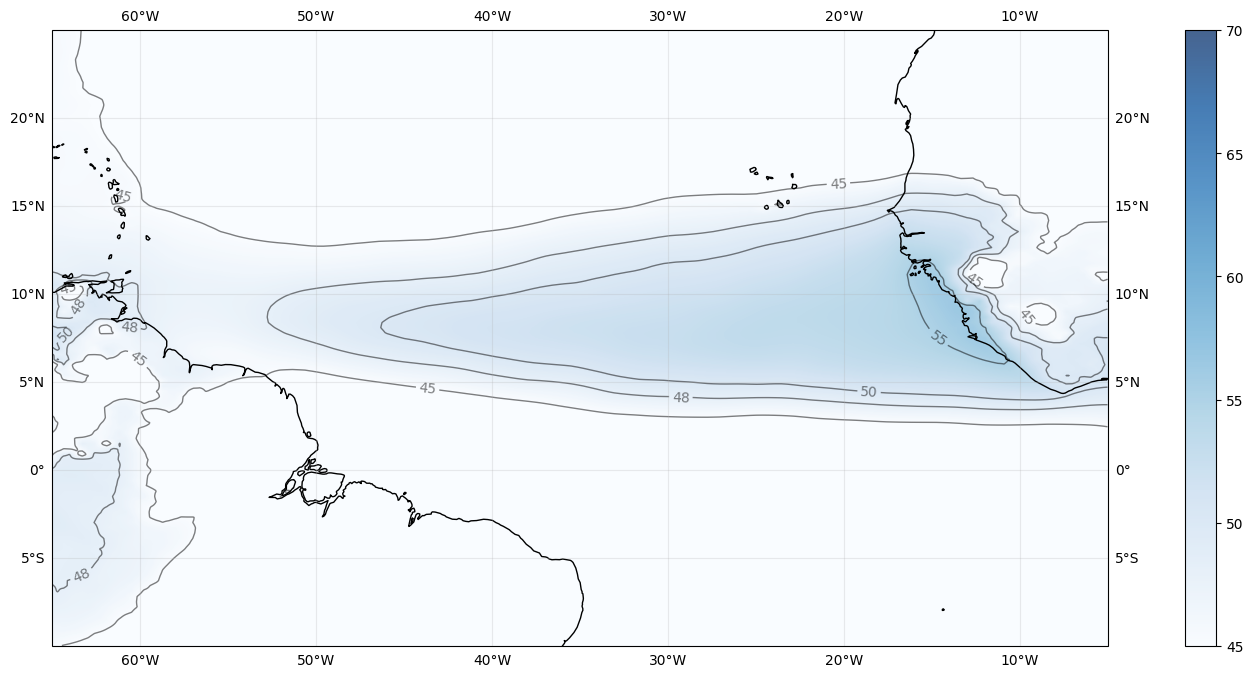

In [7]:
levels_cwv = np.sort(np.unique([cwv_thresh, 45, 50, 55]))

plt.figure(figsize = (20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-65, -5, -10, 25], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

date_sel="2016-08-08T12:00:00"

field = era5.tcwv.where(era5.time.dt.month.isin([9]), drop=True).mean("time")

im = healpix_show(field, method="linear",
                  alpha = 0.75, cmap = 'Blues', vmin = 45, vmax = 70)
plt.colorbar(im)

contour_lines = healpix_contour(field,
                                levels=levels_cwv, colors='k', linewidths=1, alpha = 0.5)

plt.clabel(contour_lines, inline=True, fontsize=10, colors='k', fmt='%d');

In [8]:
bin_to_center = lambda bins: (bins[1:]+bins[:-1])/2.0

In [9]:
def find_edges(cwv, lat_cwv_max, cwv_thresh, cwv_min = 0):
    
    """
    Determine latitude of peak in CWV that is closest to the latitude of peak CWV in the average CWV profile (lat_cwv_max).
    Assess where the moist tropics end by dropping all latitudes where CWV drops below cwv_min.
    Within the remaining moist band, assess the northernmost and southernmost latitude at which CWV is equal to cwv_thresh.
    
    If CWV is below cwv_thresh everywhere, return NAN values. 
    """

    if cwv.max().values <= cwv_thresh:
        #print("CWV below threshold value everywhere.")
        lat_north, lat_south = np.nan, np.nan

    else:

        peaks_i, peaks_props = scipy.signal.find_peaks(cwv, height=cwv_thresh, prominence=2)
        
        if len(peaks_i) == 0:
            #print("No peaks detected.")
            lat_north, lat_south = np.nan, np.nan

        else:
            dist_peaks = np.abs(lat_cwv_max - cwv.latitude[peaks_i])
            cwv_lat_max = dist_peaks.latitude[np.argmin(dist_peaks.values)]

            cwv_north = cwv.where((cwv.latitude >= cwv_lat_max) & (cwv > cwv_min), drop = True)
            cwv_south = cwv.where((cwv.latitude <= cwv_lat_max) & (cwv > cwv_min), drop = True)

            lat_north = float(cwv_north.latitude.where(cwv_north<=cwv_thresh).min().values)
            lat_south = float(cwv_south.latitude.where(cwv_south>=cwv_thresh).min().values)

    return lat_south, lat_north

In [17]:
orcestra = {"domain": {"west": [-46, -41, -5, 25], "east": [-30, -23, -5, 25]},
            "month": {"west": 9, "east": 8},
            "week": {"west": np.nan, "east": 32},
            "settings": {"cwv_thresh": cwv_thresh, "cwv_min": cwv_min, "perc_most": perc_most}
            }

In [18]:
cwv_dic = {}

for band in ["east"]:
    
    is_orcestra_region = egh.isel_extent(era5, orcestra["domain"][band]) #[W, E, S, N]

    era5_region = era5.sel(
        cell=is_orcestra_region,
    )

    era5_region_month = era5_region.where(
        (era5.time.dt.month.isin([orcestra["month"][band]]))&(
         era5.time.dt.week.isin([orcestra["week"][band]]
        )), drop=True
    )
    
    cwv_band_month_lat = era5_region_month["tcwv"].groupby(
        era5_region_month.latitude
    ).mean(
    ).compute(
    )

    cwv_band_month_profile = cwv_band_month_lat.mean("time"
    ).compute(
    )

    cwv_band_month_max = cwv_band_month_profile.where(cwv_band_month_profile == np.max(cwv_band_month_profile), drop=True).latitude.values
    
    cwv_dic[band] = {
        "cwv_region": era5_region.tcwv,
        "cwv_band_month_lat": cwv_band_month_lat, 
        "cwv_band_month_profile": cwv_band_month_profile,
        "cwv_band_month_max": cwv_band_month_max
    }

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/accessor_dt.py:407: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


In [19]:
for band in ["east"]:
    print(float(cwv_dic[band]["cwv_band_month_max"]))

8.687297821044922


In [20]:
orcestra["edges"] = {}

for band in ["east"]:
    
    print(band)
    
    cwv_band_month_lat = cwv_dic[band]["cwv_band_month_lat"]
    cwv_band_month_max = cwv_dic[band]["cwv_band_month_max"]
    
    edges = np.array([find_edges(cwv_band_month_lat.isel(time = time_ind), cwv_band_month_max, cwv_thresh, cwv_min = cwv_min) 
             for time_ind in range(len(cwv_band_month_lat.time))])

    print(f"No edges found in {np.sum(np.isnan(np.array(edges)[:,0]))/len(np.array(edges)[:,0])*100:.1f}% of the cases")

    lat_most_south = np.nanpercentile(edges[:,0], perc_most)
    lat_most_north = np.nanpercentile(edges[:,1][edges[:,0]<=lat_most_south], 100-perc_most)

    print(lat_most_south, lat_most_north)
    
    orcestra["edges"][band] = {"south": lat_most_south, "north": lat_most_north}
    
# Save the dictionary to a file
with open("orcestra.json", "w") as file:
    json.dump(orcestra, file)

east
No edges found in 0.0% of the cases
4.256345748901367 12.635624885559082


In [30]:
for perc_i in [5, 10, 30, 50, 70]:
    print(f"Percentile {perc_i}")
    
    se = np.nanpercentile(edges[:,0], perc_i)
    ne = np.nanpercentile(edges[:,1], 100-perc_i)
    
    print(f"Southern edge: {se:.2f}, Northern edge {ne:.2f}")

Percentile 5
Southern edge: 3.58, Northern edge 17.94
Percentile 10
Southern edge: 3.79, Northern edge 16.65
Percentile 30
Southern edge: 4.51, Northern edge 14.14
Percentile 50
Southern edge: 5.53, Northern edge 12.33
Percentile 70
Southern edge: 6.58, Northern edge 11.11


Determine the worst case by considering the southernmost cases and calculating the corresponding northernmost cases.

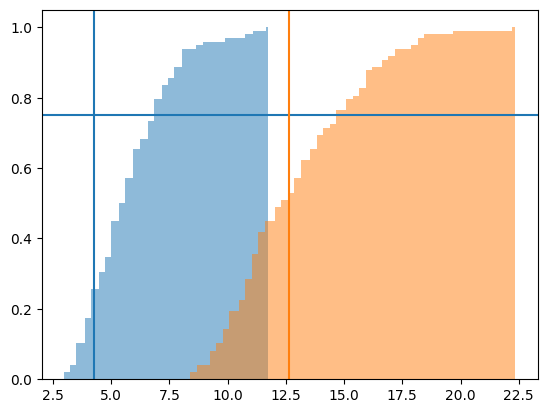

In [21]:
hist_south = plt.hist(np.array(edges)[:,0], cumulative=True, bins = 100, alpha = 0.5, density = True)
hist_north = plt.hist(np.array(edges)[:,1], cumulative=True, bins = 100, alpha = 0.5, density = True)
plt.axhline(0.75)

plt.axvline(lat_most_south)
plt.axvline(lat_most_north, color = "C1")

In [14]:
band = "east"
month = orcestra["month"][band]

levels_cwv = np.sort(np.unique([cwv_thresh, 45, 50, 55]))

plt.figure(figsize = (20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-65, -5, -10, 25], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

time_ind = np.random.randint(0, len(cwv_band_month_lat.time))
print(time_ind)

field = era5.tcwv.where(
    era5.time.dt.month.isin([month]), drop=True
).isel(time = time_ind)

im = healpix_show(field, method="linear",
                  alpha = 0.75, cmap = 'Blues', vmin = 45, vmax = 70)
plt.colorbar(im)

contour_lines = healpix_contour(field,
                                levels=levels_cwv, colors='k', linewidths=1, alpha = 0.5)

plt.clabel(contour_lines, inline=True, fontsize=10, colors='k', fmt='%d')



cwv_i = cwv_dic[band]["cwv_region"].where(
    cwv_dic[band]["cwv_region"].time.dt.month.isin([month]), drop=True
).isel(
    time = time_ind)
cwv_i = cwv_i.groupby(
    cwv_i.latitude
).mean(
).compute(
)

lat_south, lat_north = find_edges(cwv_i, cwv_band_month_max, cwv_thresh, cwv_min = cwv_min)

plt.axhline(lat_north, color = "k")
plt.axhline(lat_south, color = "k")

#plt.axhline(cwv_thresh);

73
